# *Notebook NLP*

## Sommaire

<ol>
    <li><a href="#">Import des librairies</a></li>
    <li><a href="#">Chargement des données</a></li>
    <li><a href="#">Nettoyage et analyse des reviews</a></li>
    <li><a href="#">Vectorisation</a></li>
    <li><a href="#">Topic Modeling</a></li>
    <li><a href="#">Pipeline</a></li>
    <li><a href="#">Conclusion</a></li>
</ol>

## Import des librairies

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
import emoji

from wordcloud import WordCloud

from gensim import models
from gensim.corpora.dictionary import Dictionary

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import des modules contenant les fonctions utilitaires
import src.data_helpers as dth

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,20)

## Chargement des données

On recupère le jeu de données sauvegardé à la fin de l'analyse et de la manipulation des données, ansi que celui récupéré via l'API, puis on les fusionne.

In [37]:
# Jeu de données recupéré via l'API
bad_reviews_api = pd.read_csv('bad_reviews_from_api.csv', sep=',')

In [4]:
dth.displayDataShape('Le fichier bad_reviews_api contient', bad_reviews_api)

Le fichier bad_reviews_api contient : 21 lignes et 4 colonnes



In [5]:
bad_reviews_api.head()

,business_id,categories,stars,text
0,4yPqqJDJOQX69gC66YUDkA,Restaurants,1,Really don't see the hype. Came here for lun...
1,vRrVSB-LegwUwIxpkeRVtQ,Restaurants,1,As a long time fan of Chef Eric Ripert and a w...
2,nI1UYDCYUTt23TpGxqnLKg,Restaurants,1,I have been coming to Buddakan since I moved t...
3,1DfbZ0VsSCg9g1KILmnvzQ,Restaurants,1,Possibly the worst splurge meal I've had in my...
4,M6qUGNq8_25RUs8Q9KcLaQ,Restaurants,1,My review unfortunately will not be covering t...


In [6]:
# Jeu de données issu de l'analyse
bad_reviews = pd.read_csv('bad_reviews.csv', sep=',')

In [7]:
dth.displayDataShape('Le fichier bad_reviews contient', bad_reviews)

Le fichier bad_reviews contient : 618063 lignes et 4 colonnes



In [8]:
bad_reviews.head()

,business_id,categories,stars,text
0,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,Horrible 3rd world service. After I picked out...
1,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,"Looks like a nice place from the outside, but ..."
2,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,bun is sucked here and the waitress was really...
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,TERRIBLE TERRIBLE service. I have never felt s...
4,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,Not sure what happen. I have order a taro cake...


In [9]:
# On merge ensemble les 2 jeux de données
merge_bad_reviews = pd.concat([bad_reviews, bad_reviews_api])
dth.displayDataShape('Le fichier bad_reviews contient', merge_bad_reviews)

Le fichier bad_reviews contient : 618084 lignes et 4 colonnes



Pour limiter les temps de calcul par la suite, on ne garde que 50 000 reviews choisies aléatoirement.

In [10]:
sample_reviews = merge_bad_reviews.sample(n = 50000)
sample_reviews

,business_id,categories,stars,text
560201,brlew1UwRlO6Qj9QlQ-WWQ,"Coffee & Tea, Food, Donuts",1.0,Lady wouldn't stop rushing me out of the drive...
615862,8Pw3gUxSISkGqWNOsdWQ4Q,"Restaurants, Taiwanese, Thai",1.0,I've had Thai all over the country and this is...
213047,YbE-dvcWOgTGPbvkYxr9XA,"Restaurants, Tex-Mex, Ethiopian, Fast Food, Me...",1.0,The food here is okay. Perhaps a little bland ...
483727,TXRBp01bIr60dSGYsu8oxQ,"Restaurants, Italian",1.0,I had been to this location a few times around...
507401,o69X6XW8QLuluIoGqvtQrA,"Nightlife, Wine Bars, Bars, Pizza, Restaurants...",1.0,My husband and I were looking forward to a gre...
...,...,...,...,...
231578,omWpYUw3JyoZOAHl2EeXLQ,"Nightlife, Restaurants, American (New), Bars, ...",1.0,I don't honestly know which is worse the virt...
274364,rPXuIXd4S4XQABrU1dfSXA,"Sandwiches, Restaurants, Fast Food, Burgers",1.0,This is the worst burger king I have ever gone...
448984,7hxKhNTk2mTF6bNMTwx6pQ,"Restaurants, Mexican",1.0,I was very disappointed.... from the very warm...
67561,X58bbekzeDgD-UHcjfEOIg,"Chicken Wings, Nightlife, Sports Bars, America...",1.0,After a terrible lunch experience last month w...


## Nettoyage et analyse des reviews

On va commencer par créer une première fonction afin de nettoyer les reviews de notre data de cette manière :
- Remplacement des emojis par son équivalent en mot
- Suppression de la ponctuation et des nombres
- Mettre le texte en minuscule
- Tokenizer notre texte (un token = 1 mot, chaque review est donc sous la forme d'un tableau de mots (de tokens))

In [11]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

# Notre fonction de nettoyage et de tokenization
def tokenize_text(text):
    return tokenizer.tokenize(emoji.demojize(text, delimiters=("", "")).lower())

1er Nettoyage :

In [12]:
# Création d'un corpus de tokens
corpus = []
for row in sample_reviews.index:
    corpus.append(tokenize_text(sample_reviews['text'][row]))

# Calcul des fréquences des mots dans chaque texte
freq = []
for row in corpus:
    freq.append(nltk.FreqDist(row))

# Fréquence totale de chaque mot pour l'ensemble du corpus
freq_totale = nltk.Counter()
for fr in freq:
    freq_totale += fr

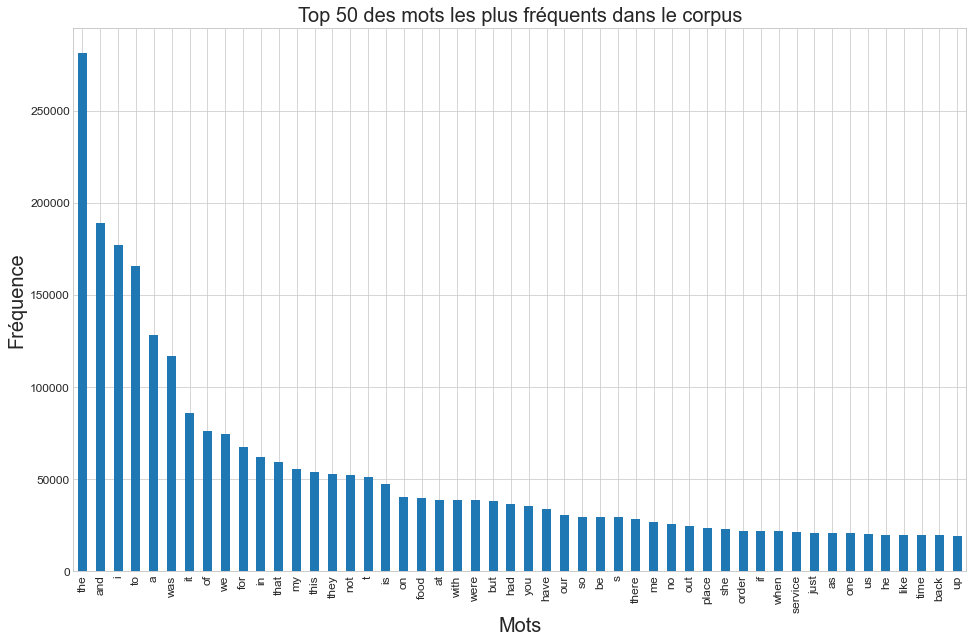

In [14]:
dth.display_word_freq_hist(freq_totale, 50)

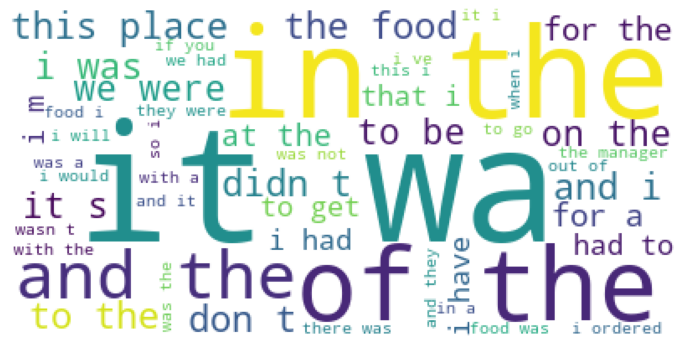

In [38]:
dth.display_wordcloud(corpus, 50)

Ce premier nettoyage a permis de supprimer les éléments superflus de nos reviews et de les tokeniser.
Le problème est que les mots restants les plus fréquents n'ont pas de sens car ils sont trop communs, il est inutile de les garder.

On va donc procéder à un second nettoyage :

- Supprimer les stop words (les mots communs qui n'ont pas de sens)
- Supprimer les mots de 3 lettres ou moins
- Lemmatiser (récupérer la forme neutre canonique des mots)

2nd Nettoyage :

In [15]:
# Récupération des stop words en Anglais
sw = set()
sw.update(tuple(stopwords.words('english')))

In [16]:

lemmatizer = WordNetLemmatizer()

# Création d'un corpus de tokens
corpus_2 = []
for row in sample_reviews.index:
    tokens = tokenize_text(sample_reviews['text'][row])
    corpus_2.append([lemmatizer.lemmatize(w) for w in tokens if w not in sw and len(w) > 3])

# Calcul des fréquences des mots dans chaque texte
freq_2 = []
for row in corpus_2:
    freq_2.append(nltk.FreqDist(row))

# Fréquence totale de chaque mot pour l'ensemble du corpus
freq_totale_2 = nltk.Counter()
for fr in freq_2:
    freq_totale_2 += fr

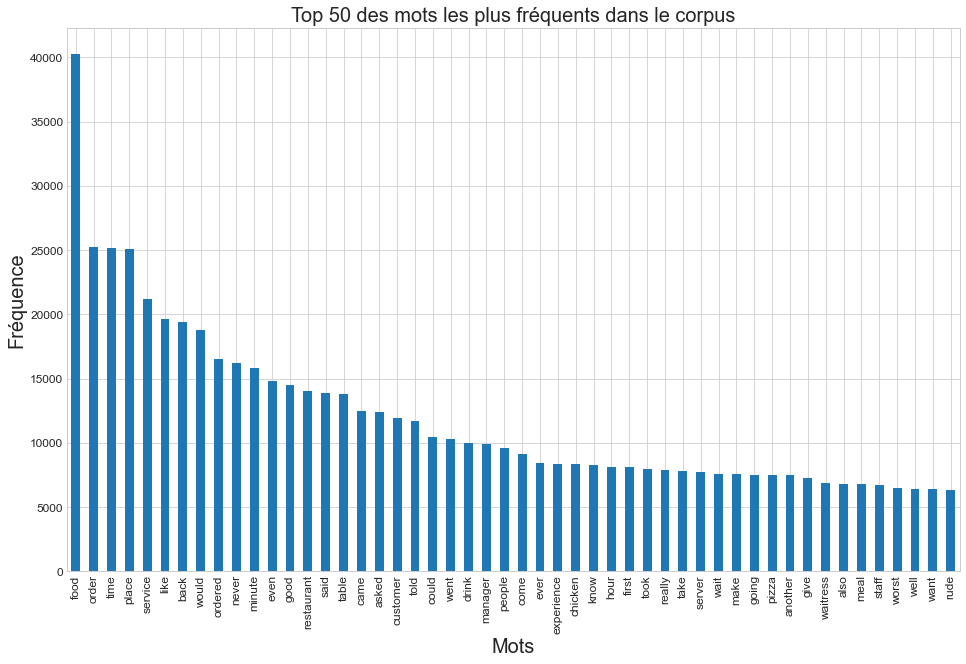

In [18]:
dth.display_word_freq_hist(freq_totale_2, 50)

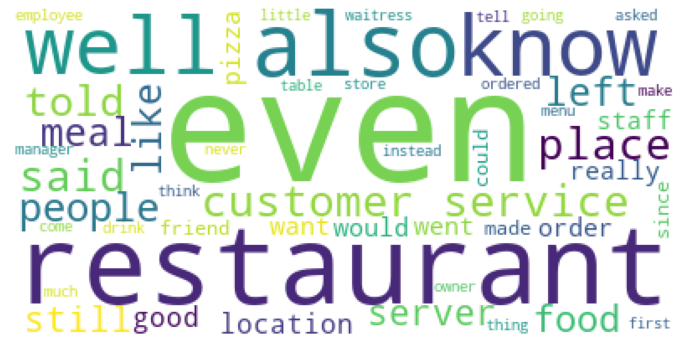

In [39]:
dth.display_wordcloud(corpus_2, 50)

Après ce second nettoyage, notre tokenisation a déjà beaucoup plus de sens. Les mots les plus fréquents peuvent être associés à un topic.

Cela nous donne également un aperçu de ce qui ressort le plus souvent dans les mauvaises reviews.

## Vectorisation

Ici on va créer une matrice de taille "nbr reviews * taille du vocabulaire" suivant 2 méthodes :

- CountVectorizer : calculer pour chaque review la fréquence d'apparition des différents mots de tous le vocabulaire
- TfidfVectorizer : calculer pour chaque review un rapport entre la fréquence d'apparition des mots dans la review et dans le corpus total

Ces matrices sont ensuites utilisées par nos algorithmes pour faire par exemple du topic modeling.

On va ici effectuer cette vectorisation à titre d'exemple, car les algorithmes de la librairie Gensim que nous utiliserons par la suite, incluent déjà dans leur pipeline la vectorisation.

In [19]:
def tokenize(text):
    tokens = tokenize_text(text)
    return [lemmatizer.lemmatize(w) for w in tokens if w not in sw and len(w) > 3]
    

In [20]:
cv = CountVectorizer(tokenizer=tokenize, stop_words=sw)
data_cv = cv.fit_transform(sample_reviews['text'])
data_cv_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_cv_dtm.index = sample_reviews.index
data_cv_dtm

,aaaaaaaaaahhh,aaaaaaand,aaaaaggah,aaaaany,aaaand,aaagggh,aaawwww,aaccess,aagain,aahh,...,zuppa,zuppas,zuppe,zushi,zuul,zuzu,zville,zxrlcoew,zydeco,zzzzzzzzz
560201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
615862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
213047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
483727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
448984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
data_tfidf = tfidf.fit_transform(sample_reviews['text'])
data_tfidf_dtm = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names_out())
data_tfidf_dtm.index = sample_reviews.index
data_tfidf_dtm

,aaaaaaaaaahhh,aaaaaaand,aaaaaggah,aaaaany,aaaand,aaagggh,aaawwww,aaccess,aagain,aahh,...,zuppa,zuppas,zuppe,zushi,zuul,zuzu,zville,zxrlcoew,zydeco,zzzzzzzzz
560201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modeling

In [22]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(corpus_2)
common_corpus = [common_dictionary.doc2bow(text) for text in corpus_2]

In [23]:
lda = models.LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=4)
lda.print_topics()

[(0,
  '0.014*"order" + 0.013*"customer" + 0.011*"time" + 0.011*"said" + 0.010*"would" + 0.010*"told" + 0.008*"back" + 0.008*"service" + 0.007*"manager" + 0.007*"people"'),
 (1,
  '0.016*"food" + 0.015*"like" + 0.013*"ordered" + 0.013*"place" + 0.012*"chicken" + 0.010*"good" + 0.008*"pizza" + 0.007*"sauce" + 0.007*"cheese" + 0.006*"salad"'),
 (2,
  '0.027*"food" + 0.023*"order" + 0.019*"minute" + 0.019*"time" + 0.016*"service" + 0.014*"back" + 0.014*"came" + 0.013*"never" + 0.013*"ordered" + 0.011*"drink"'),
 (3,
  '0.021*"food" + 0.014*"place" + 0.014*"restaurant" + 0.013*"table" + 0.010*"service" + 0.009*"good" + 0.007*"would" + 0.006*"experience" + 0.006*"like" + 0.006*"server"')]

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(common_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = models.CoherenceModel(model=lda, texts=corpus_2, dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.470829256437539

Coherence Score:  0.41562718226889545


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)

C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.123446  0.013355       1        1  30.170948
1     -0.167402  0.030686       2        1  24.315603
3     -0.003373 -0.109911       3        1  22.811299
2      0.047329  0.065870       4        1  22.702151, topic_info=        Term          Freq         Total Category  logprob  loglift
108   minute  15457.000000  15457.000000  Default  30.0000  30.0000
203    order  25250.000000  25250.000000  Default  29.0000  29.0000
60   chicken   8363.000000   8363.000000  Default  28.0000  28.0000
236    table  14364.000000  14364.000000  Default  27.0000  27.0000
115  ordered  16785.000000  16785.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
296    worst   2902.362949   6405.732191   Topic4  -5.2732   0.6910
154     told   3456.035017  11663.871349   Topic4  -5.0986   0.2663
159    would   3873.183721  18807.884583   Topic4  -4.9846  -0.0975
119    place   4128.030023  25451.418086   Topic4  -4.9209  -0.3363
557     take   3051.509338   7753.712265   Topic4  -5.2231   0.5502

[407 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3377      1  0.987772      act
4454      1  0.969505  address
4454      2  0.011433  address
4454      3  0.009146  address
4454      4  0.011433  address
...     ...       ...      ...
159       4  0.205924    would
297       1  0.288193    wrong
297       2  0.111410    wrong
297       3  0.031305    wrong
297       4  0.569021    wrong

[997 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

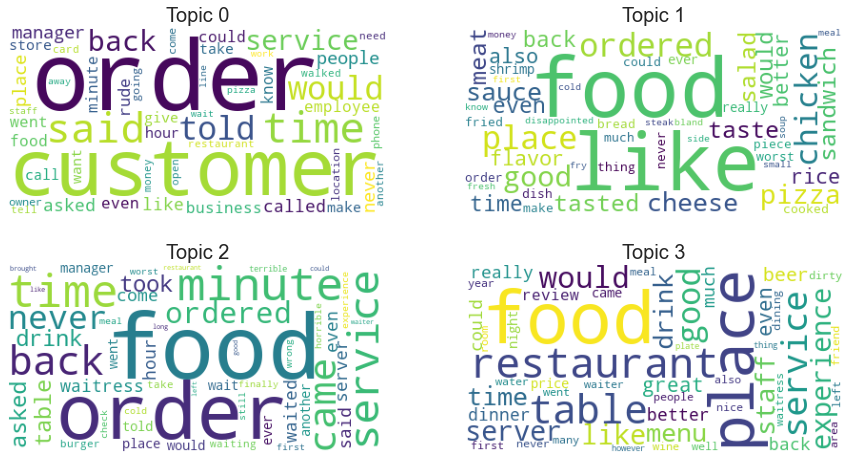

In [26]:
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

In [27]:
lemmatizer = WordNetLemmatizer()

# Création d'un corpus de tokens
corpus_3 = []
for row in sample_reviews.index:
    tokens = tokenize_text(sample_reviews['text'][row])
    corpus_3.append([lemmatizer.lemmatize(w) for w in tokens if w not in sw and len(w) > 3])

# On garde seulement les noms et les adjectifs
corpus_3_cleaned = []
for element in corpus_3:
    pos_tag = nltk.pos_tag(element)
    if len(pos_tag) > 1:
        pos_tag_cleaned = list(zip(*[word for word in pos_tag if word[1] == 'NN']))
        if len(pos_tag_cleaned) > 1 :
            corpus_3_cleaned.append(list(pos_tag_cleaned[0]))

# Calcul des fréquences des mots dans chaque texte
freq_3 = []
for row in corpus_3_cleaned:
    freq_3.append(nltk.FreqDist(row))

# Fréquence totale de chaque mot pour l'ensemble du corpus
freq_totale_3 = nltk.Counter()
for fr in freq_3:
    freq_totale_3 += fr

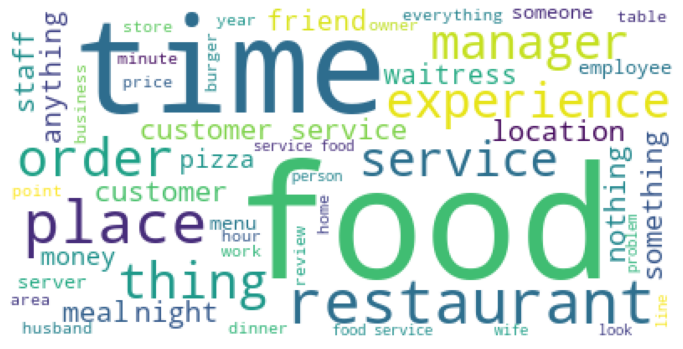

In [28]:
dth.display_wordcloud(corpus_3_cleaned, 50)

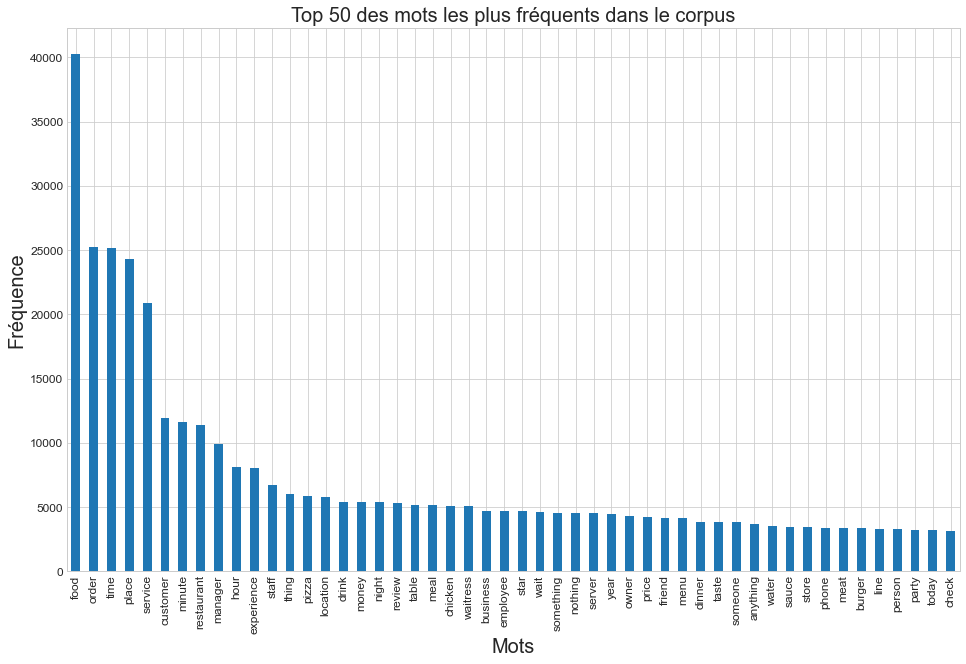

In [29]:
dth.display_word_freq_hist(freq_totale_3, 50)

In [30]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(corpus_3_cleaned)
common_corpus = [common_dictionary.doc2bow(text) for text in corpus_3_cleaned]

lda = models.LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=4)
lda.print_topics()

[(0,
  '0.051*"food" + 0.022*"chicken" + 0.022*"place" + 0.015*"restaurant" + 0.014*"sauce" + 0.014*"meat" + 0.014*"taste" + 0.013*"rice" + 0.011*"flavor" + 0.011*"meal"'),
 (1,
  '0.039*"food" + 0.030*"place" + 0.024*"time" + 0.013*"burger" + 0.013*"service" + 0.011*"order" + 0.011*"drink" + 0.010*"coffee" + 0.010*"beer" + 0.010*"water"'),
 (2,
  '0.052*"order" + 0.034*"time" + 0.030*"food" + 0.026*"service" + 0.022*"minute" + 0.022*"manager" + 0.021*"customer" + 0.011*"hour" + 0.011*"location" + 0.010*"experience"'),
 (3,
  '0.046*"place" + 0.042*"food" + 0.033*"service" + 0.030*"pizza" + 0.021*"time" + 0.021*"restaurant" + 0.019*"owner" + 0.019*"customer" + 0.016*"business" + 0.013*"staff"')]

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(common_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = models.CoherenceModel(model=lda, texts=corpus_3_cleaned, dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9015891086937575

Coherence Score:  0.5522311244138213


In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)

C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.133734 -0.033583       1        1  37.897761
1     -0.021780 -0.116246       2        1  23.384769
0     -0.214307  0.042241       3        1  20.249811
3      0.102352  0.107589       4        1  18.467659, topic_info=         Term          Freq         Total Category  logprob  loglift
301     pizza   5697.000000   5697.000000  Default  30.0000  30.0000
83      order  25110.000000  25110.000000  Default  29.0000  29.0000
48      place  24342.000000  24342.000000  Default  28.0000  28.0000
19    chicken   5189.000000   5189.000000  Default  27.0000  27.0000
0    customer  12057.000000  12057.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
83      order   1517.687477  25110.646682   Topic4  -4.8410  -1.1170
51      price    825.825559   4366.637057   Topic4  -5.4496   0.0238
81      night    848.847618   5160.489226   Topic4  -5.4221  -0.1158
77    manager    885.734233  10140.647270   Topic4  -5.3795  -0.7487
89    quality    739.528109   2852.197751   Topic4  -5.5599   0.3393

[365 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
835       1  0.988739  advantage
4995      2  0.006601    alfredo
4995      3  0.990089    alfredo
229       1  0.265305       area
229       2  0.210744       area
...     ...       ...        ...
161       4  0.262153       year
116       1  0.107680       yelp
116       2  0.077454       yelp
116       3  0.148296       yelp
116       4  0.667805       yelp

[829 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

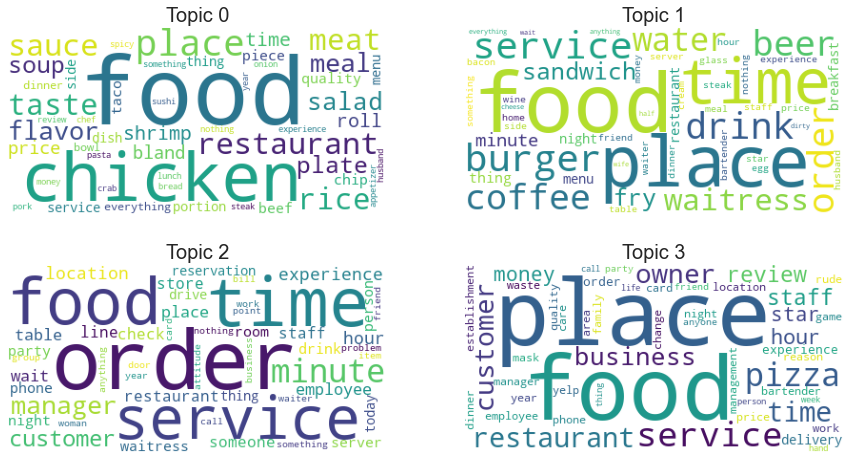

In [33]:
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

In [34]:
def compute_coherence_values(dictionnary, corpus, texts):

    coherences_values = []
    model_list = []

    for num_topic in range(2, 21, 1):
        model = models.LdaModel(corpus=corpus, id2word=dictionnary, num_topics=num_topic)
        model_list.append(model)

        coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionnary, coherence='c_v')
        coherences_values.append(coherence_model.get_coherence())
    
    return model_list, coherences_values

In [35]:
model_list, coherence_values = compute_coherence_values(common_dictionary, common_corpus, corpus_3_cleaned)

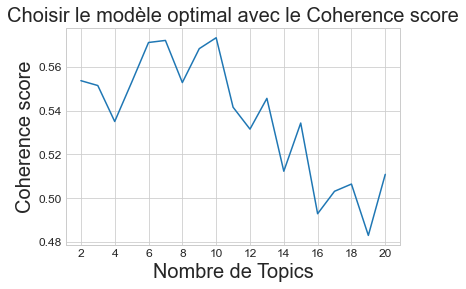

In [36]:
# Show graph
x = range(2, 21, 1)
plt.plot(x, coherence_values)
plt.xticks(range(2, 21, 2))
plt.xlabel("Nombre de Topics")
plt.ylabel("Coherence score")
plt.title("Choisir le modèle optimal avec le Coherence score")
plt.show()